# Прогнозирование уровня средней заработной платы в России

Известны данные о заработной плате за каждый месяц с января 1993 по август 2016, необходимо построить прогноз на каждый месяц на два года врерёд.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
salary = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
salary.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


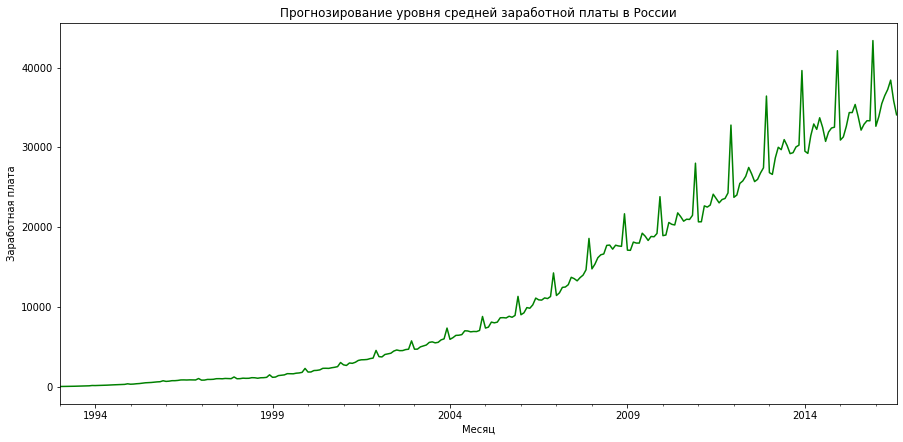

In [34]:
plt.figure(figsize(15,7))
salary.WAG_C_M.plot(color='green')
plt.xlabel('Месяц')
plt.ylabel('Заработная плата')
plt.title('Прогнозирование уровня средней заработной платы в России')
plt.show()

Проверка стационарности и STL-декомпозиция ряда:

<Figure size 1080x720 with 0 Axes>

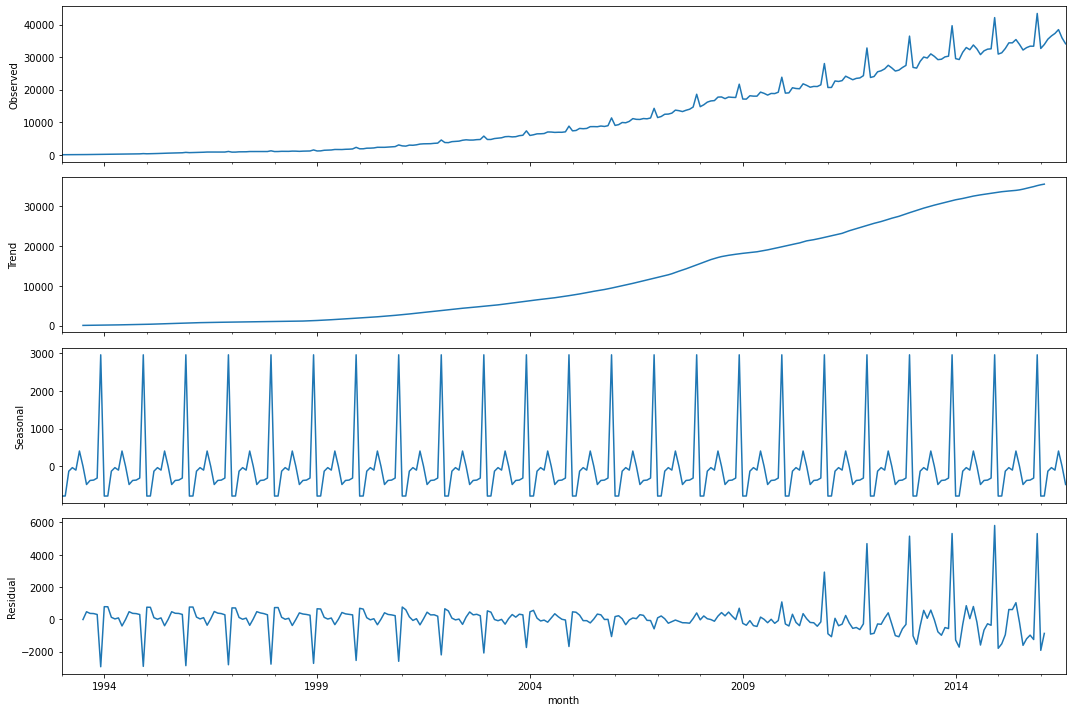

Критерий Дики-Фуллера: p=0.991850


In [42]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M).plot()
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

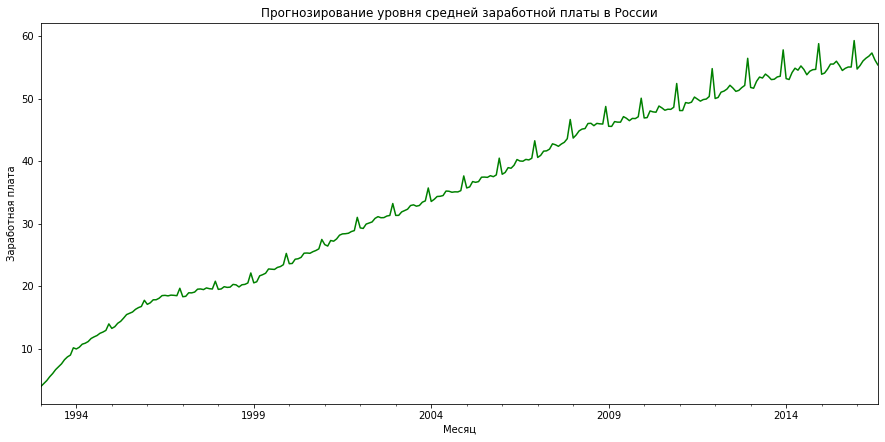

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


In [38]:
salary['sales_box'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
salary.sales_box.plot(color='green')
plt.xlabel('Месяц')
plt.ylabel('Заработная плата')
plt.title('Прогнозирование уровня средней заработной платы в России')
plt.show()
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.sales_box)[1])

### Стационарность

Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

<Figure size 1080x720 with 0 Axes>

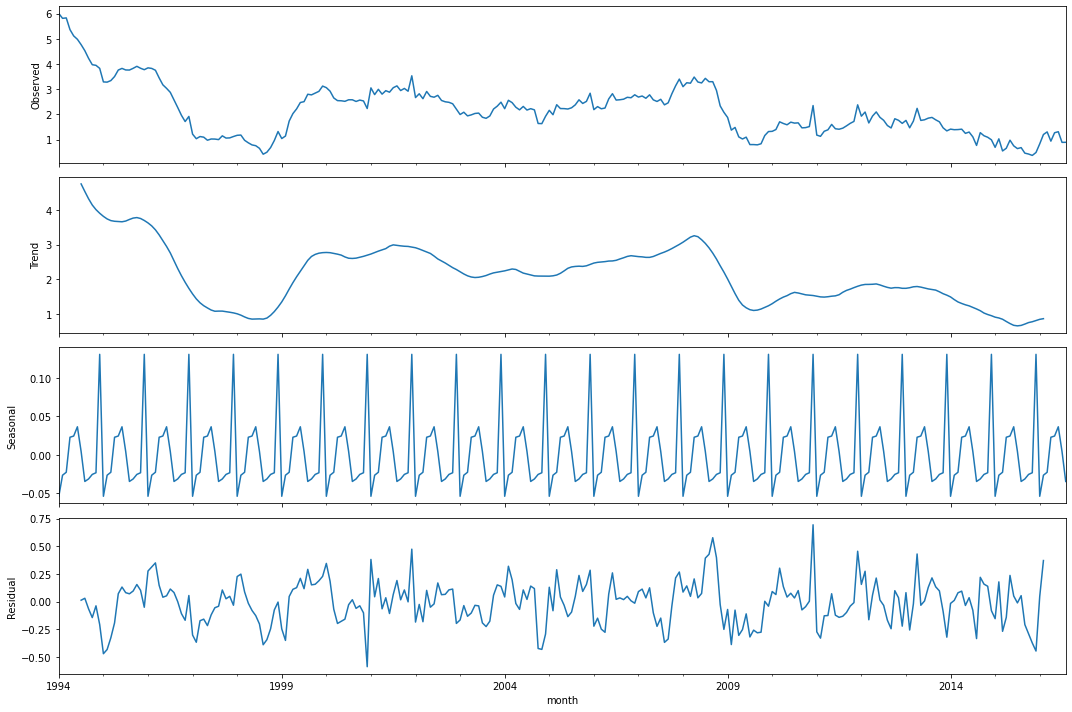

Критерий Дики-Фуллера: p=0.014697


In [43]:
salary['sales_box_diff'] = salary.sales_box - salary.sales_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.sales_box_diff[12:]).plot()
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.sales_box_diff[12:])[1])

Попробуем добавить ещё обычное дифференцирование:

<Figure size 1080x720 with 0 Axes>

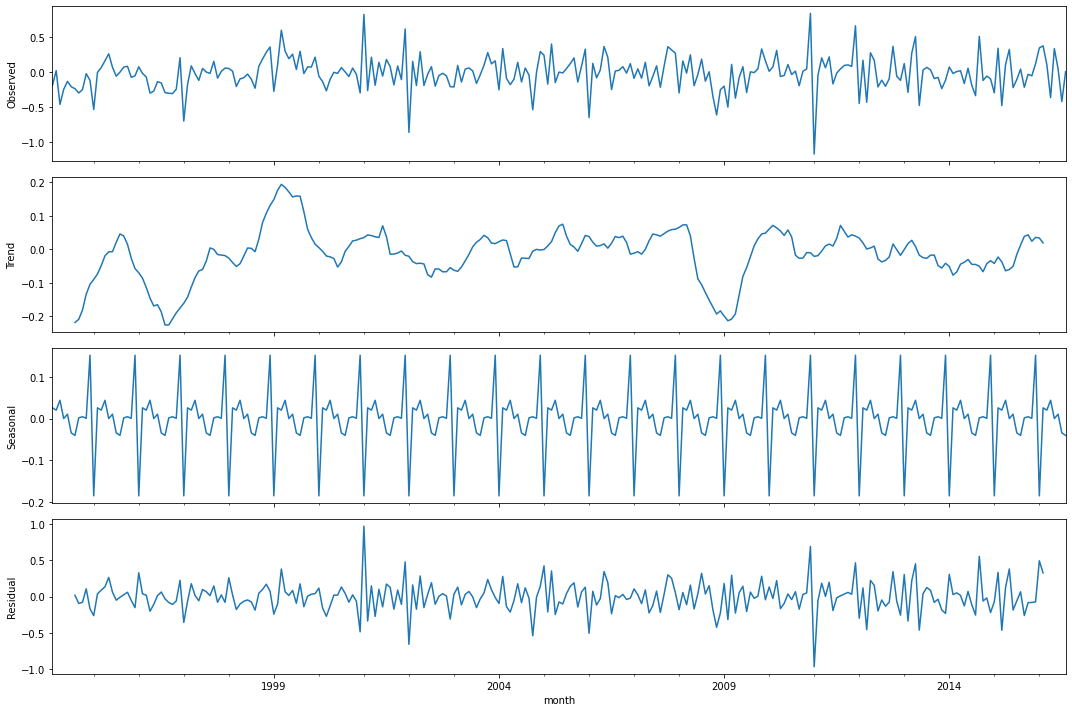

Критерий Дики-Фуллера: p=0.000000


In [44]:
salary['sales_box_diff2'] = salary.sales_box_diff - salary.sales_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.sales_box_diff2[13:]).plot()   
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.sales_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lags = lags.astype(np.float)


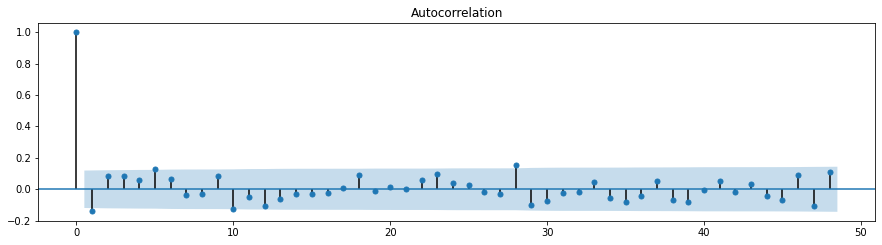

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lags = lags.astype(np.float)


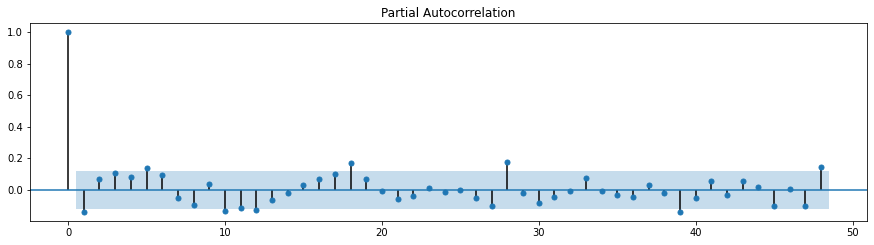

In [45]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

In [14]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 4)
D=1
Qs = range(0, 1)

In [15]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [16]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 12.5 s, sys: 8.86 s, total: 21.4 s
Wall time: 11 s


In [17]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
9   (1, 0, 1, 0)  0.340521
5   (0, 1, 1, 0)  1.170768
10  (1, 0, 2, 0)  1.622924
13  (1, 1, 1, 0)  2.021911
6   (0, 1, 2, 0)  2.509650


Лучшая модель:

In [18]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          sales_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Mon, 23 May 2022   AIC                              0.341
Time:                                    08:26:06   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Её остатки:

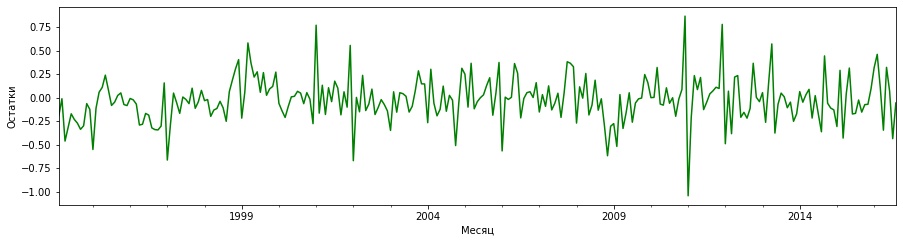

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lags = lags.astype(np.float)


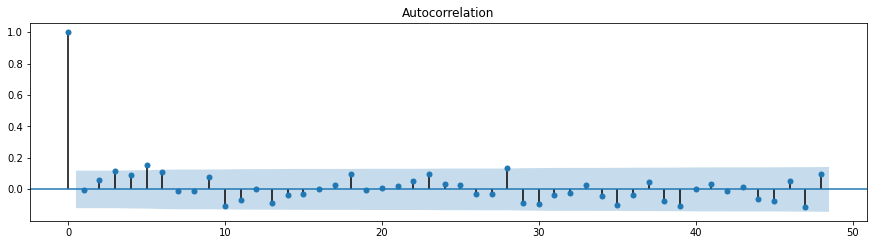

Критерий Стьюдента: p=0.090798
Критерий Дики-Фуллера: p=0.000003


In [47]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot(color='green')
plt.xlabel('Месяц')
plt.ylabel('Остатки')
plt.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

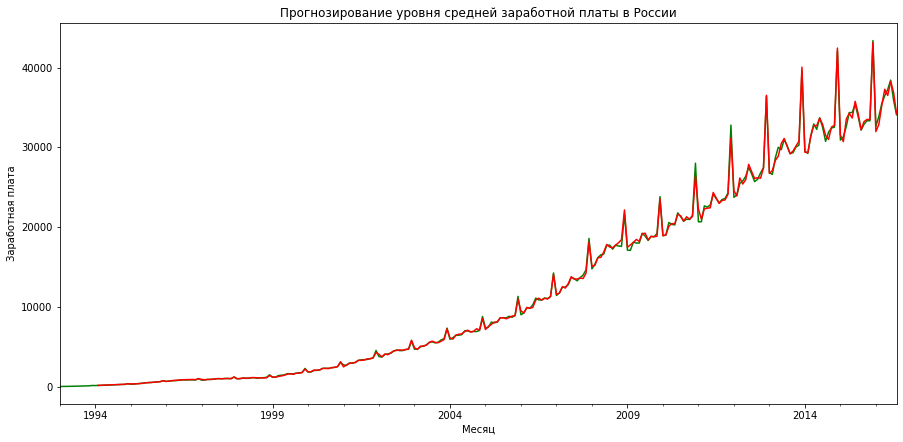

In [50]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot(color='green')
salary.model[13:].plot(color='red')
plt.title('Прогнозирование уровня средней заработной платы в России')
plt.xlabel('Месяц')
plt.ylabel('Заработная плата')
plt.show()

### Прогноз

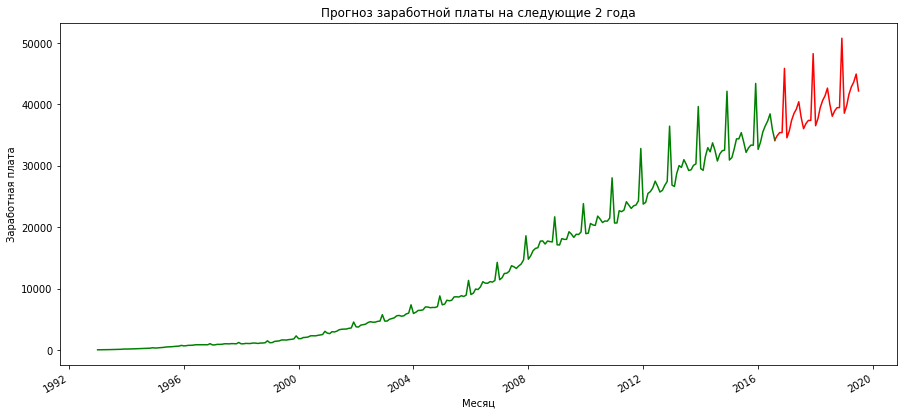

In [52]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=283, end=320), lmbda)

plt.figure(figsize(15,7))
salary2.WAG_C_M.plot(color='green')
salary2.forecast.plot(color='red')
plt.title('Прогноз заработной платы на следующие 2 года')
plt.xlabel('Месяц')
plt.ylabel('Заработная плата')
plt.show()